# **News Headlines Text Generation**

In this notebook, we made a text generation model to generate news headline using data  published in New York Times in Jan-May 2017 to Jan-April 2018. <br> more info for the dataset: https://www.kaggle.com/datasets/aashita/nyt-comments

Workflow:
1. Tokenize the headlines and convert them into n_gram sequences.
2. Apply padding to the sequences to equal the length.
3. Split the sequences into features and labels.
4. Build a bidirectional lstm model.
5. Generate some headlines using the trained model.

# **Imports**

In [1]:
import string, os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

# **Data Review**

In [2]:
data_dir = '../input/nyt-comments/'

all_headlines = []
for filename in os.listdir(data_dir):
    if 'Articles' in filename:
        article_df = pd.read_csv(data_dir + filename)
        all_headlines.extend(list(article_df.headline.values))
        break

all_headlines = [h for h in all_headlines if h != "Unknown"]

linebreak = "\n"

print(f'There are {len(all_headlines)} headlines.')
print(f'Some examples: \n {linebreak.join(all_headlines[:10])}')

There are 829 headlines.
Some examples: 
 N.F.L. vs. Politics Has Been Battle All Season Long
Voice. Vice. Veracity.
A Stand-Up’s Downward Slide
New York Today: A Groundhog Has Her Day
A Swimmer’s Communion With the Ocean
Trail Activity
Super Bowl
Trump’s Mexican Shakedown
Pence’s Presidential Pet
Fruit of a Poison Tree


# **Data Processing**

**Data cleaning**

In [3]:
# remove punctuation and lower the texts
def clean_text(txt):
    txt = "".join(v for v in txt if v not in string.punctuation).lower()
    #txt = txt.encode("utf8").decode("ascii",'ignore')
    return txt 

corpus = [clean_text(x) for x in all_headlines]
corpus[:10]

['nfl vs politics has been battle all season long',
 'voice vice veracity',
 'a standup’s downward slide',
 'new york today a groundhog has her day',
 'a swimmer’s communion with the ocean',
 'trail activity',
 'super bowl',
 'trump’s mexican shakedown',
 'pence’s presidential pet',
 'fruit of a poison tree']

**Tokenize and get n_gram_sequences**

In [4]:
# tokenizing the text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [5]:
# generate a list of n-gram sequences

def n_gram_seqs(corpus, tokenizer):
    input_sequences = []
    
    for line in corpus:
        counter = 1
        sequences = tokenizer.texts_to_sequences([line])[0]
        while counter < len(sequences):
            input_sequences.append(sequences[:counter+1])
            counter += 1
    
    return input_sequences

In [6]:
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[649, 115],
 [649, 115, 90],
 [649, 115, 90, 73],
 [649, 115, 90, 73, 650],
 [649, 115, 90, 73, 650, 651],
 [649, 115, 90, 73, 650, 651, 63],
 [649, 115, 90, 73, 650, 651, 63, 27],
 [649, 115, 90, 73, 650, 651, 63, 27, 208]]

In [7]:
# apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# save max length 
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 4554
maximum length of sequences is: 18


**Add padding to the sequences to even the length**

In [8]:
# pad tokenized sequences to the same length
def pad_seqs(input_sequences, maxlen):
    
    padded_sequences = pad_sequences(input_sequences, maxlen=maxlen+1)
    
    return padded_sequences


In [9]:
print("padded n_gram sequences for first example look like this:\n")
first_padded_seq = pad_seqs(first_example_sequence, len(first_example_sequence))
first_padded_seq

padded n_gram sequences for first example look like this:



array([[  0,   0,   0,   0,   0,   0,   0, 649, 115],
       [  0,   0,   0,   0,   0,   0, 649, 115,  90],
       [  0,   0,   0,   0,   0, 649, 115,  90,  73],
       [  0,   0,   0,   0, 649, 115,  90,  73, 650],
       [  0,   0,   0, 649, 115,  90,  73, 650, 651],
       [  0,   0, 649, 115,  90,  73, 650, 651,  63],
       [  0, 649, 115,  90,  73, 650, 651,  63,  27],
       [649, 115,  90,  73, 650, 651,  63,  27, 208]], dtype=int32)

In [10]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (4554, 19)


**Split padded sequences into features and labels**

In [11]:
# generates features and labels from n-grams
def features_and_labels(input_sequences, total_words):

    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = to_categorical(labels, num_classes=total_words)

    return features, one_hot_labels

In [12]:
# Test padded n_grams_seq of the first example
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}")
print("\nfeatures look like this:\n")
first_features

labels have shape: (8, 2357)

features look like this:



array([[  0,   0,   0,   0,   0,   0,   0, 649],
       [  0,   0,   0,   0,   0,   0, 649, 115],
       [  0,   0,   0,   0,   0, 649, 115,  90],
       [  0,   0,   0,   0, 649, 115,  90,  73],
       [  0,   0,   0, 649, 115,  90,  73, 650],
       [  0,   0, 649, 115,  90,  73, 650, 651],
       [  0, 649, 115,  90,  73, 650, 651,  63],
       [649, 115,  90,  73, 650, 651,  63,  27]], dtype=int32)

In [13]:
# split the whole corpus into features and labels
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (4554, 18)
labels have shape: (4554, 2357)


# **Model Building & Training**

In [14]:
# create a text generator model
def create_model(total_words, max_sequence_len):
    model = Sequential()
    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
    model.add(Bidirectional(LSTM(150)))
    model.add(Dense(total_words, activation="softmax"))

    # Compile the model
    model.compile(loss="categorical_crossentropy",
                  optimizer="nadam",
                  metrics=['accuracy'])

    return model

In [15]:
# create an untrained model
model = create_model(total_words, max_sequence_len)

# train the model
history = model.fit(features, labels, epochs=50, verbose=1)

2022-12-22 04:10:57.213525: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-12-22 04:10:58.116420: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
143/143 [==============================] - 11s 46ms/step - loss: 7.3327 - accuracy: 0.0349
Epoch 2/50
143/143 [==============================] - 7s 46ms/step - loss: 6.8339 - accuracy: 0.0378
Epoch 3/50
143/143 [==============================] - 7s 50ms/step - loss: 6.6800 - accuracy: 0.0389
Epoch 4/50
143/143 [==============================] - 6s 45ms/step - loss: 6.5154 - accuracy: 0.0457
Epoch 5/50
143/143 [==============================] - 6s 45ms/step - loss: 6.2962 - accuracy: 0.0529
Epoch 6/50
143/143 [==============================] - 6s 45ms/step - loss: 6.0298 - accuracy: 0.0648
Epoch 7/50
143/143 [==============================] - 6s 45ms/step - loss: 5.7130 - accuracy: 0.0720
Epoch 8/50
143/143 [==============================] - 7s 50ms/step - loss: 5.3782 - accuracy: 0.0810
Epoch 9/50
143/143 [==============================] - 6s 45ms/step - loss: 5.0400 - accuracy: 0.0964
Epoch 10/50
143/143 [==============================] - 6s 44ms/step - loss: 4.6972 - accur

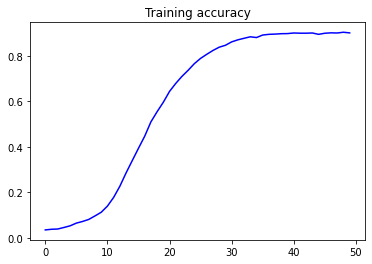

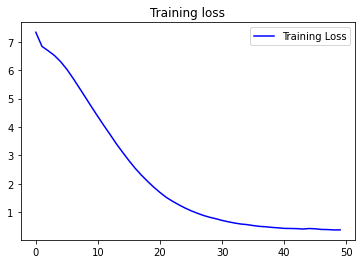

In [16]:
# plot the training result
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

# **Testing**

In [17]:
# generate some text using the trained model
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        # Convert the text into sequences
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # Pad the sequences
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        # Get the probabilities of predicting a word
        predicted = model.predict(token_list, verbose=0)
        # Choose the next word based on the maximum probability
        predicted = np.argmax(predicted, axis=-1).item()
        # Get the actual word from the word index
        output_word = tokenizer.index_word[predicted]
        # Append to the current text
        seed_text += " " + output_word
    return seed_text.title()

In [18]:
print (generate_text("united states", 4, model, max_sequence_len))
print (generate_text("china", 4, model, max_sequence_len))
print (generate_text("donald trump", 4, model, max_sequence_len))
print (generate_text("global economy", 4, model, max_sequence_len))
print (generate_text("deep learning", 3, model, max_sequence_len))

United States Spends On Risks As
China Wants To Attract More
Donald Trump Will Numb You You
Global Economy From Your Readers Led
Deep Learning Are It Rising
